# **Colab 用户注意**

# **请勿直接在此文件中编辑——你的内容可能会丢失！**

# **开始前务必先复制一份。**

如何复制文件

1. 点击左上角的“File”。
> *如果看不到菜单栏（比如“File”或“Runtime”），点击右上角的“v”图标来显示它。*

2. 选择“Save a copy in Drive”。

3. 把复制的文件重命名为“你的名字_FileName.ipynb”。
> 例如：如果你叫 Olivia，就改成 Olivias_FileName.ipynb。



---

* 打勾标记（✅）不会被保存。如果用 Chrome 的刷新按钮重载页面，标记会消失。<br>
如果想暂停，稍后再做，只需新建一个文本单元，写上“SO FAR DONE”之类的提示即可。

---

* 在 Colab 中，**之前的输出会每隔30到90分钟被清空一次**。<br>
  这很可能让你频繁遇到 `~~ is not defined` 的错误。

  🔁 遇到 `~~ is not defined` 错误怎么办  
  1. 先确认变量拼写完全正确。<br>
  2. 拼写没错但仍然出错，**点击你想重新运行的那个单元格**。<br>
  3. 点击左上角“Runtime” → 选择“Run before”。<br>
    → 这会**重新运行之前所有的单元格**。  
  4. 再运行该单元格。

  如果这样做后仍报错，可能是你之前回答的代码有根本性错误。<br>
  请检查你写的代码是否正确，或者求助 ChatGPT 或其他编程助手。

# **Chapter 3: PositionEmbedding**

### **Section 0: Preparation**

本节仅加载前面章节的内容。<br>
直接运行代码就行，无需阅读。<br>
你也可以直接跳过。<br>

In [ ]:
# 下载文件
!wget https://raw.githubusercontent.com/HayatoHongo/Everyones_nanoGPT/main/input.txt -O input.txt
# 加载刚下载的名为 input.text 的文件，编码为 utf-8。
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

# 一个用于美观显示张量的函数（可跳过）
import torch
import torch.nn as nn

def print_formatted_tensor(*args, width=6, decimals=2):
    """
        A function that neatly formats and displays a PyTorch Tensor, and also prints its size.

    Example usage:
        print_formatted_tensor("姓名", tensor)
        print_formatted_tensor(tensor)

    Args:
        *args: If given 1 argument, it is treated as a tensor.
               If given 2 arguments, the first is treated as the name, the second as the tensor.
        width (int): Display width for each number (default: 6)
        decimals (int): Number of decimal places to show (default: 2)
    """
    将英文注释、文档字符串和 print 语句简洁、友好、自然地翻译成简体中文。
    # 根据参数确定张量和名称
    if not args:
        raise ValueError("At least one argument is required.")
    if isinstance(args[0], str):
        if len(args) < 2:
            raise ValueError("Tensor is not specified.")
        name, tensor = args[0], args[1]
    else:
        name, tensor = None, args[0]

    # 将张量转换为列表
    tensor_list = tensor.detach().cpu().tolist()

    def format_list(lst, indent):
        """格式化递归嵌套列表并返回字符串"""
        # 如果内容是列表，则重新返回
        if isinstance(lst, list) and lst and isinstance(lst[0], list):
            inner = ",\n".join(" " * indent + format_list(sub, indent + 2) for sub in lst)
            return "[\n" + inner + "\n" + " " * (indent - 2) + "]"
        # 针对数字列表
        return "[" + ", ".join(f"{v:{width}.{decimals}f}" for v in lst) + "]"

    # 格式化字符串（最外层框架的花括号已移除）
    formatted = format_list(tensor_list, indent=9)
    inner_formatted = formatted[1:-1].strip()

    # 结果输出
    if name:
        print(name)
    print(f"Tensor Size: {list(tensor.size())}")
    print("张量([")
    print("" * 9 + inner_formatted)
    print("" * 7 + "])")

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # 定义一个嵌入表，用于词汇量为 x，嵌入维度为 number 的嵌入向量
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)

    def embed(self, input_indices):
        # 获取对应输入索引的嵌入向量
        return self.token_embedding_table.forward(input_indices)

--2025-07-03 10:50:43--  https://raw.githubusercontent.com/HayatoHongo/nanoGPT_todo/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-07-03 10:50:44 (66.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



### **Section 1: __init__**

**什么是 Positional Embedding？**  
通常，Token Embedding 会给每个字母或单词分配一个固定的向量。  
但这样一来，同一个字母（比如 “L”）无论出现在什么位置，得到的向量都一样。  
这就忽略了位置信息。  

然而，单词或字母的**位置**对于理解上下文至关重要。  
这就是 **Positional Embedding** 的用武之地。  

Positional Embedding 是一种用数值向量表示序列数据（比如字符串）中的**位置**的方法。  
比如，一个句子的第1个字母、第2个字母、第3个字母，都会有各自独特的位置向量。  

将这些位置向量加到 Token Embeddings 上，模型就能**知道每个词出现在哪里**。  
这样，模型可以更好地理解上下文，处理语言更自然。  
  
---

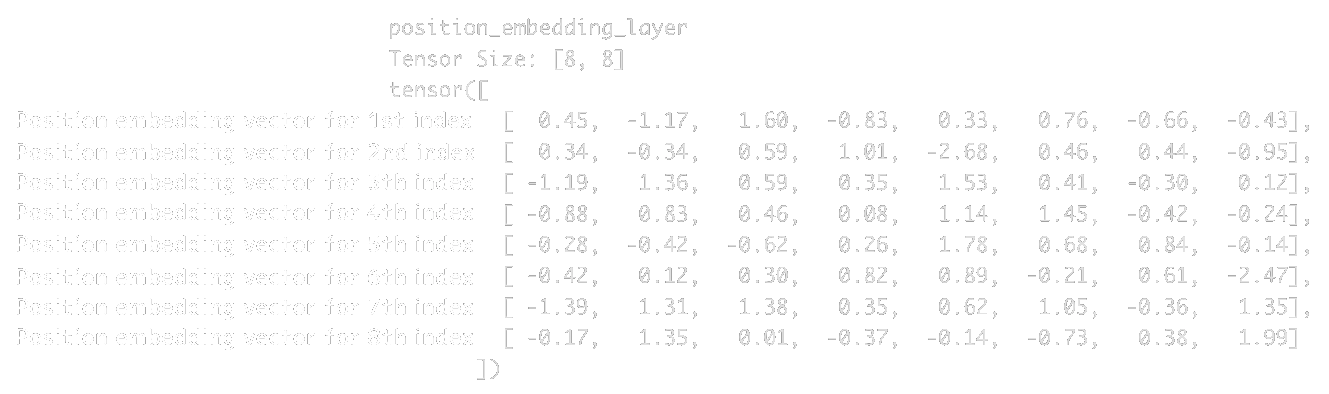

**Learnable Positional Embedding**  
Learnable positional embedding 给每个位置分配一个**可训练向量**，就像词元嵌入一样。<br>  
它初始是随机值。<br>  
这种方法被 BERT、GPT、ViT 等采用。<br>  
优点是能适应数据。<br>  
现在已广泛取代了传统的正弦位置编码。<br>  
注意不要和更常见的正弦位置编码混淆。<br>  

| Positional Embedding | Features                    | Models Adopted               |
|----------------------|-----------------------------|-----------------------------|
| **Sinusoidal PE**    | 公式固定，不可训练           | Transformer 原始论文 (Vaswani et al., 2017) |
| **Learnable PE**     | 用 `nn.Embedding`，可训练     | BERT、GPT、ViT              |
| **Relative PE**      | 考虑相对位置                 | ALiBi、T5 等                |

创建嵌入层

```python
Class: nn.Embedding
Arguments:
  - num_embeddings: 嵌入字典的大小 (=8)
  - embedding_dim: 每个嵌入向量的维度 (=8)
```
- `nn.Embedding(8, 8)` 创建了一个把 8 个元素（位置）转换成 8 维嵌入向量的层。
- 这个层把位置信息表示成 8 维特征向量。<br>它的维度与 `TokenEmbedding` 的嵌入维度相匹配。

In [ ]:
torch.manual_seed(1337)
token_embedding_layer = nn.Embedding(65, 8)

# 创建嵌入层
position_embedding_layer = nn.Embedding(num_embeddings = 8, embedding_dim = 8) # TODO: nn.Embedding(嵌入字典大小, 嵌入向量维度)
print_formatted_tensor("位置嵌入层", position_embedding_layer.weight)

position_embedding_layer
Tensor Size: [8, 8]
tensor([
         [  0.45,  -1.17,   1.60,  -0.83,   0.33,   0.76,  -0.66,  -0.43],
         [  0.34,  -0.34,   0.59,   1.01,  -2.68,   0.46,   0.44,  -0.95],
         [ -1.19,   1.36,   0.59,   0.35,   1.53,   0.41,  -0.30,   0.12],
         [ -0.88,   0.83,   0.46,   0.08,   1.14,   1.45,  -0.42,  -0.24],
         [ -0.28,  -0.42,  -0.62,   0.26,   1.78,   0.68,   0.84,  -0.14],
         [ -0.42,   0.12,   0.30,   0.82,   0.89,  -0.21,   0.61,  -2.47],
         [ -1.39,   1.31,   1.38,   0.35,   0.62,   1.05,  -0.36,   1.35],
         [ -0.17,   1.35,   0.01,  -0.37,  -0.14,  -0.73,   0.38,   1.99]
       ])


**Section 1: init** <label><input type="checkbox"> 标记为完成</label>

### **Section 2: Forward**

获取指定位置的嵌入向量

```python
Instance: position_embedding_layer
Method: forward or optional
Argument: torch.tensor([2])
```
- 从嵌入层 position_embedding_layer 中获取索引为 `2`（第3个字符）的嵌入向量。

In [ ]:
# 获取特定位置（索引2）的嵌入向量
position_embedding_for_third_position = position_embedding_layer(torch.tensor([2])) # TODO: 实例.方法(参数)
print_formatted_tensor(position_embedding_for_third_position)

Tensor Size: [1, 8]
tensor([
         [ -1.19,   1.36,   0.59,   0.35,   1.53,   0.41,  -0.30,   0.12]
       ])


创建位置索引列表

```python
Function: torch.arange
Argument: 8
```
- `torch.arange(8)` 会创建一个包含从0到7连续整数的张量。


In [ ]:
position_indices = torch.arange(8) # TODO: 创建一个包含从0到7的整数的张量
print_formatted_tensor(position_indices)

Tensor Size: [8]
tensor([
         0.00,   1.00,   2.00,   3.00,   4.00,   5.00,   6.00,   7.00
       ])


获取位置索引的嵌入向量

```python
Instance: position_embedding_layer
Method: forward or optional
Argument: position_indices
```
- 为给定的`position_indices`获取一系列嵌入向量。


In [ ]:
position_embeddings = position_embedding_layer.forward(position_indices) # TODO: 实例.方法(参数)
print_formatted_tensor("位置嵌入", position_embeddings)

position_embeddings
Tensor Size: [8, 8]
tensor([
         [  0.45,  -1.17,   1.60,  -0.83,   0.33,   0.76,  -0.66,  -0.43],
         [  0.34,  -0.34,   0.59,   1.01,  -2.68,   0.46,   0.44,  -0.95],
         [ -1.19,   1.36,   0.59,   0.35,   1.53,   0.41,  -0.30,   0.12],
         [ -0.88,   0.83,   0.46,   0.08,   1.14,   1.45,  -0.42,  -0.24],
         [ -0.28,  -0.42,  -0.62,   0.26,   1.78,   0.68,   0.84,  -0.14],
         [ -0.42,   0.12,   0.30,   0.82,   0.89,  -0.21,   0.61,  -2.47],
         [ -1.39,   1.31,   1.38,   0.35,   0.62,   1.05,  -0.36,   1.35],
         [ -0.17,   1.35,   0.01,  -0.37,  -0.14,  -0.73,   0.38,   1.99]
       ])


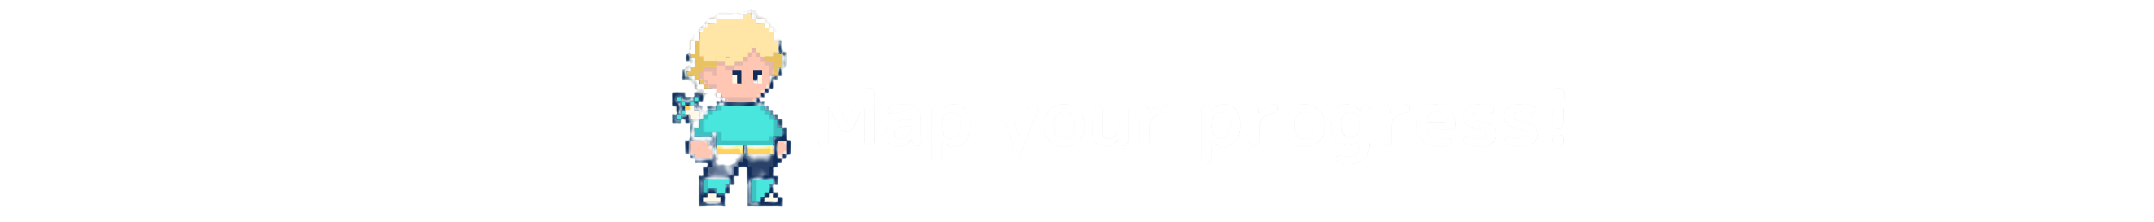

由于它只处理位置，上面的嵌入字典可用于任意8字符字符串。<br>
（里面的数字会在训练中变化。）

**Section 2: forward** <label><input type="checkbox"> 标记为已完成</label>

### **Section 3: 定义一个类**

🔘 **Options**: 可能有一些额外的选项你用不到。

`Embedding`  `arange`  `1`  `0`  `position_embedding_layer.forward`  `zeros`


In [ ]:
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批量大小，序列长度]。
        sequence_length = input_indices.shape[1]

        # 根据序列长度创建位置索引（例如：[0, 1, 2, ..., sequence_length-1]）
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # 获取位置索引对应的嵌入向量
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings

In [ ]:
"""
将英文注释、文档字符串和 print 语句简洁、友好、自然地翻译成简体中文。class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn._____(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批次大小，序列长度]。
        sequence_length = input_indices.shape[_____]

        # 根据序列长度创建位置索引（例如：[0, 1, 2, ..., sequence_length-1]）
        position_indices = torch._____(sequence_length, device=input_indices.device)

        # 获取位置索引的嵌入向量
        position_embeddings = self._____(position_indices)

        return position_embeddings
"""
将英文注释、文档字符串和打印语句简洁友好地翻译成简体中文。

'\nclass PositionEmbedding(nn.Module):\n    def __init__(self, input_sequence_length = 8, embedding_dim = 8):\n        super().__init__()\n        # Location embedding layer\n        self.position_embedding_layer = nn._____(input_sequence_length, embedding_dim)\n\n    def forward(self, input_indices):\n        # The shape of the input tensor input_indices: [batch size, sequence length].\n        sequence_length = input_indices.shape[_____]\n\n        # Create a position index according to the sequence length (e.g. [0, 1, 2, ..., sequence_length-1])\n        position_indices = torch._____(sequence_length, device=input_indices.device)\n\n        # Get the embedded vector for the position index\n        position_embeddings = self._____(position_indices)\n\n        return position_embeddings\n'

<details>
<summary>点击这里显示/隐藏答案</summary>

```python
class PositionEmbedding(nn.Module):
    def __init__(self, input_sequence_length = 8, embedding_dim = 8):
        super().__init__()
        # 位置嵌入层
        self.position_embedding_layer = nn.Embedding(input_sequence_length, embedding_dim)

    def forward(self, input_indices):
        # 输入张量 input_indices 的形状：[批量大小, 序列长度]。
        sequence_length = input_indices.shape[1]

        # 根据序列长度创建位置索引（例如 [0, 1, 2, ..., sequence_length-1]）
        position_indices = torch.arange(sequence_length, device=input_indices.device)

        # 获取位置索引对应的嵌入向量
        position_embeddings = self.position_embedding_layer.forward(position_indices)

        return position_embeddings
```

**模块操作检查**

In [ ]:
# 存储模型设置的配置类
class ModelConfig:
    batch_size = 1  # 每次处理的数据量（批量大小）
    input_sequence_length = 8  # 输入数据长度（序列长度）
    embedding_dim = 8  # 嵌入层大小（特征向量的维度数）

```python
类：PositionEmbedding
参数：input_sequence_length = （使用配置），embedding_dim = （使用配置）

实例 = 类（参数）
```

In [ ]:
# 检查模块的运行情况
torch.manual_seed(1337)

config = ModelConfig()
token_embedding_layer = TokenEmbedding(vocab_size = 65, embedding_dim = config.embedding_dim)

position_embedding_layer = PositionEmbedding(input_sequence_length=config.input_sequence_length, embedding_dim=config.embedding_dim) # TODO: 创建一个位置嵌入层的实例

```python
Instance: position_embedding_layer
Method: forward (optional)
Argument: sample_input_tokens

position_embeddings = Instance.Method(argument)
```

In [ ]:
# 兼容 Let's he。 （批次大小，令牌长度）=（1，8）
sample_input_tokens = torch.tensor([[24, 43, 58, 5, 57, 1, 46, 43]])
position_embeddings = position_embedding_layer.forward(sample_input_tokens) # TODO: 计算 sample_input_tokens 的位置嵌入
print_formatted_tensor("位置嵌入", position_embeddings)

position_embeddings
Tensor Size: [8, 8]
tensor([
         [  0.45,  -1.17,   1.60,  -0.83,   0.33,   0.76,  -0.66,  -0.43],
         [  0.34,  -0.34,   0.59,   1.01,  -2.68,   0.46,   0.44,  -0.95],
         [ -1.19,   1.36,   0.59,   0.35,   1.53,   0.41,  -0.30,   0.12],
         [ -0.88,   0.83,   0.46,   0.08,   1.14,   1.45,  -0.42,  -0.24],
         [ -0.28,  -0.42,  -0.62,   0.26,   1.78,   0.68,   0.84,  -0.14],
         [ -0.42,   0.12,   0.30,   0.82,   0.89,  -0.21,   0.61,  -2.47],
         [ -1.39,   1.31,   1.38,   0.35,   0.62,   1.05,  -0.36,   1.35],
         [ -0.17,   1.35,   0.01,  -0.37,  -0.14,  -0.73,   0.38,   1.99]
       ])


位置嵌入是根据每个 token 在序列中的位置生成的，<br>
因此对每个 batch 都是一样的。它们没有 batch 维度。<br>

假设你将形状为 [8, 8] 的 `position embeddings` 加到形状为 [32, 8, 8] 的 `token embeddings` 张量上，<br>
不会报错。<br>
PyTorch 会自动把位置嵌入复制 32 份，加到每个 batch 上。<br>
这种自动扩展叫做“广播”(broadcasting)。

在 PyTorch 中，很多操作无论有没有 batch 维度都能正常工作。<br>

**Section 3: Define a Class** <label><input type="checkbox"> 标记为完成</label>

**`Check Point`**  <label><input type="checkbox">  Chapter 3: PositionEmbedding Class  
</label>